In [1]:
!pip install sdv
!pip install table-evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 4.7 MB/s 
     |████████████████████████████████| 131 kB 31.4 MB/s 
     |████████████████████████████████| 61 kB 402 kB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 47 kB 4.6 MB/s 
     |████████████████████████████████| 1.6 MB 65.9 MB/s 
     |████████████████████████████████| 11.2 MB 76.9 MB/s 
     |████████████████████████████████| 960 kB 76.7 MB/s 
     |████████████████████████████████| 636 kB 54.2 MB/s 
     |████████████████████████████████| 281 kB 90.6 MB/s 
     |████████████████████████████████| 15.2 MB 56.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 7.4 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [3]:
from google.colab import files
uploaded = files.upload()

Saving adult.csv to adult.csv


In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sdv.tabular import CopulaGAN
from sdv.sampling import Condition
from table_evaluator import TableEvaluator

import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [5]:
real_data = pd.read_csv('adult.csv')
real_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [6]:
real_data.shape

(48842, 15)

In [7]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [8]:
metadata = {
    'fields' :{
        'age' : {'type' : 'numerical', 'subtype' : 'integer'},
        'workclass' : {'type' : 'categorical'},
        'fnlwgt' : {'type' : 'numerical', 'subtype' : 'integer'},
        'education' : {'categorical'},
        'educational-num' : {'type' : 'numerical', 'subtype' : 'integer'},
        'marital-status' : {'type' : 'categorical'},
        'occupation' : {'type' : 'categorical'},
        'relationship' : {'type' : 'categorical'},
        'race' : {'type' : 'categorical'},
        'gender' : {'type' : 'categorical'},
        'capital-gain' : {'type' : 'numerical', 'subtype' : 'integer'},
        'capital-loss' : {'type' : 'numerical', 'subtype' : 'integer'},
        'hours-per-week' : {'type' : 'numerical', 'subtype' : 'integer'},
        'native-country' : {'type' : 'categorical'},
        'income' : {'type' : 'categorical'}
    }
}

In [9]:
model = CopulaGAN() 
model.fit(real_data)

In [10]:
condition_0 = Condition({      
        'income': '<=50K'
          }, num_rows=37155)

condition_1 = Condition({      
        'income': '>50K'
          }, num_rows=11687)

In [11]:
synthetic_data_0 = model.sample_conditions(conditions=[condition_0])
synthetic_data_1 = model.sample_conditions(conditions=[condition_1])

Sampling conditions: 100%|██████████| 11687/11687 [00:01<00:00, 6437.66it/s]


In [12]:
synthetic_data = pd.concat([synthetic_data_0,synthetic_data_1])
synthetic_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,28,Private,421412,HS-grad,9,Married-spouse-absent,Transport-moving,Unmarried,White,Male,0,0,40,United-States,<=50K
1,38,Private,146148,HS-grad,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
2,58,Private,100955,5th-6th,3,Married-spouse-absent,Other-service,Other-relative,White,Male,0,0,21,Mexico,<=50K
3,36,Private,100018,Masters,14,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Male,0,0,40,Philippines,<=50K
4,31,Private,169094,Bachelors,13,Married-spouse-absent,Exec-managerial,Not-in-family,Asian-Pac-Islander,Male,0,1793,40,Ireland,<=50K


Real Data vs Synthetic Data

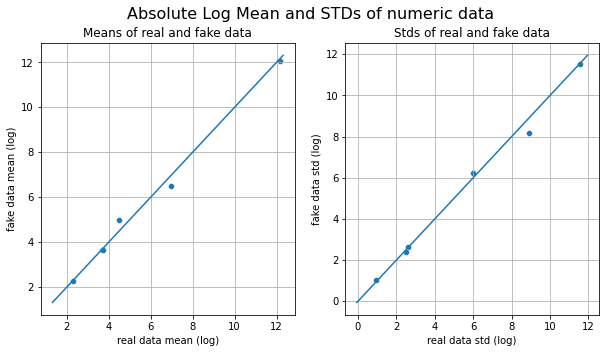

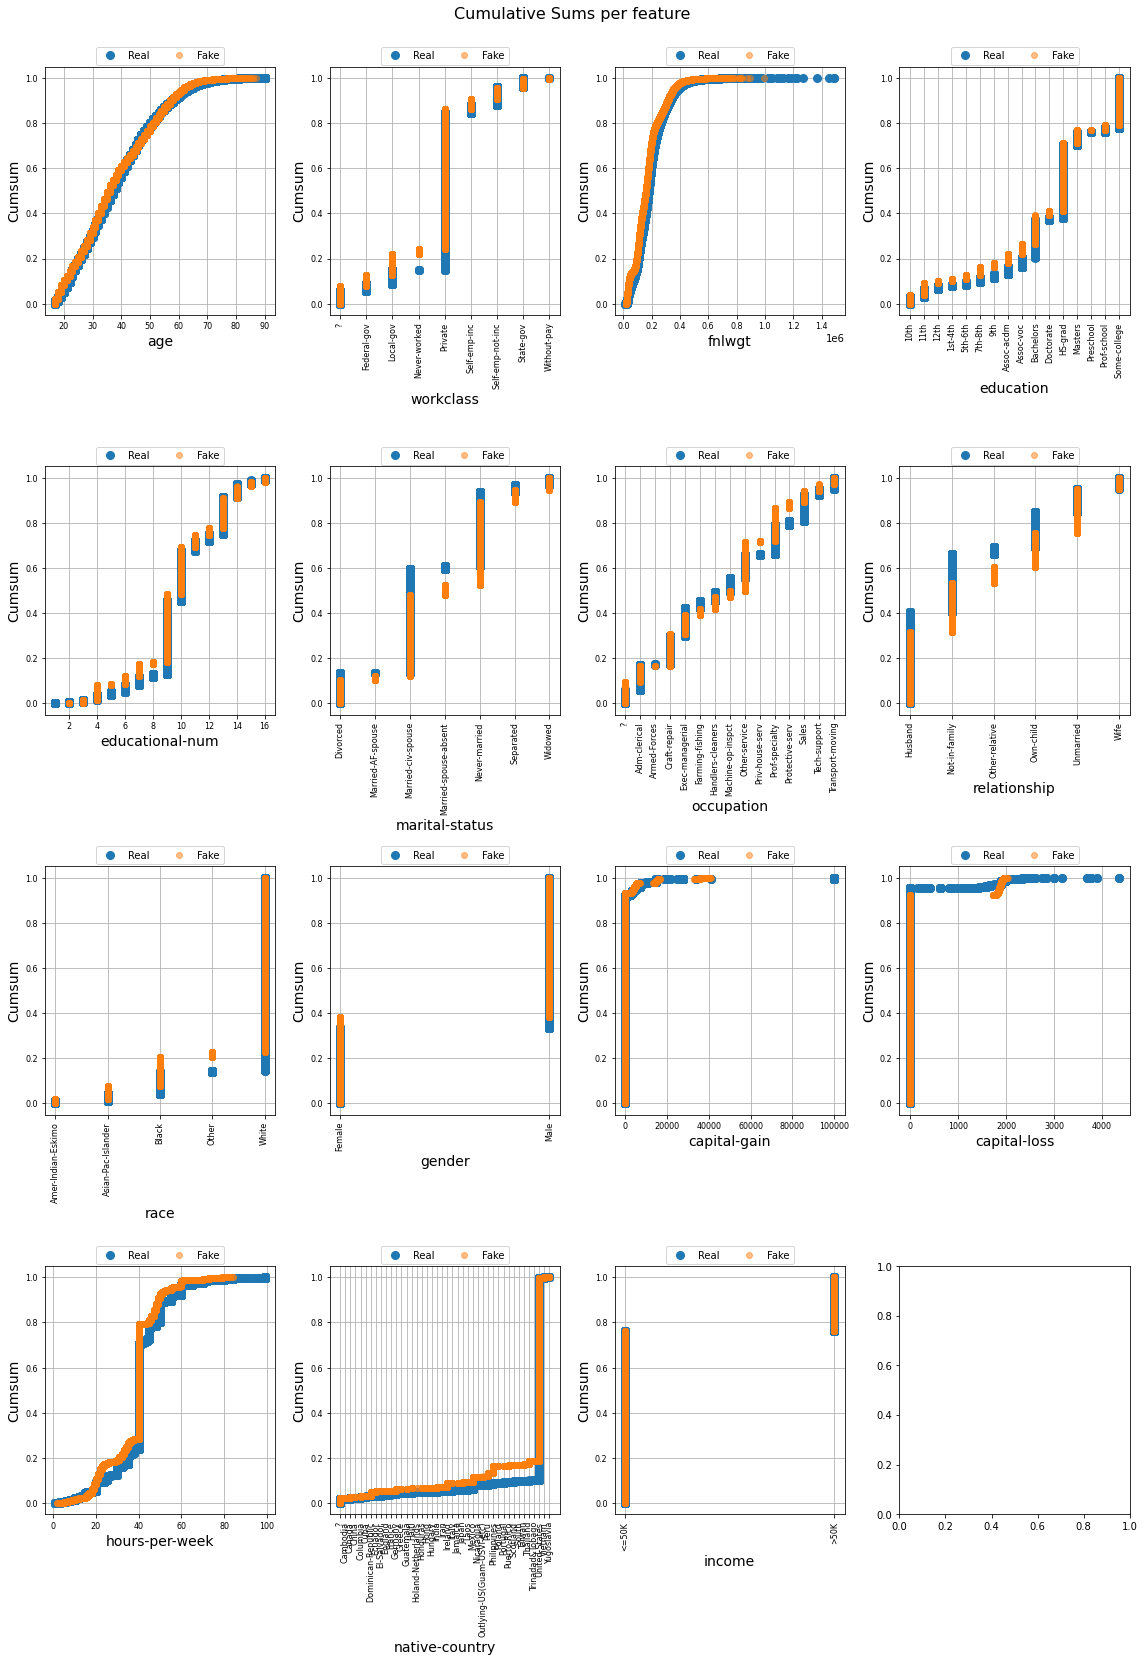

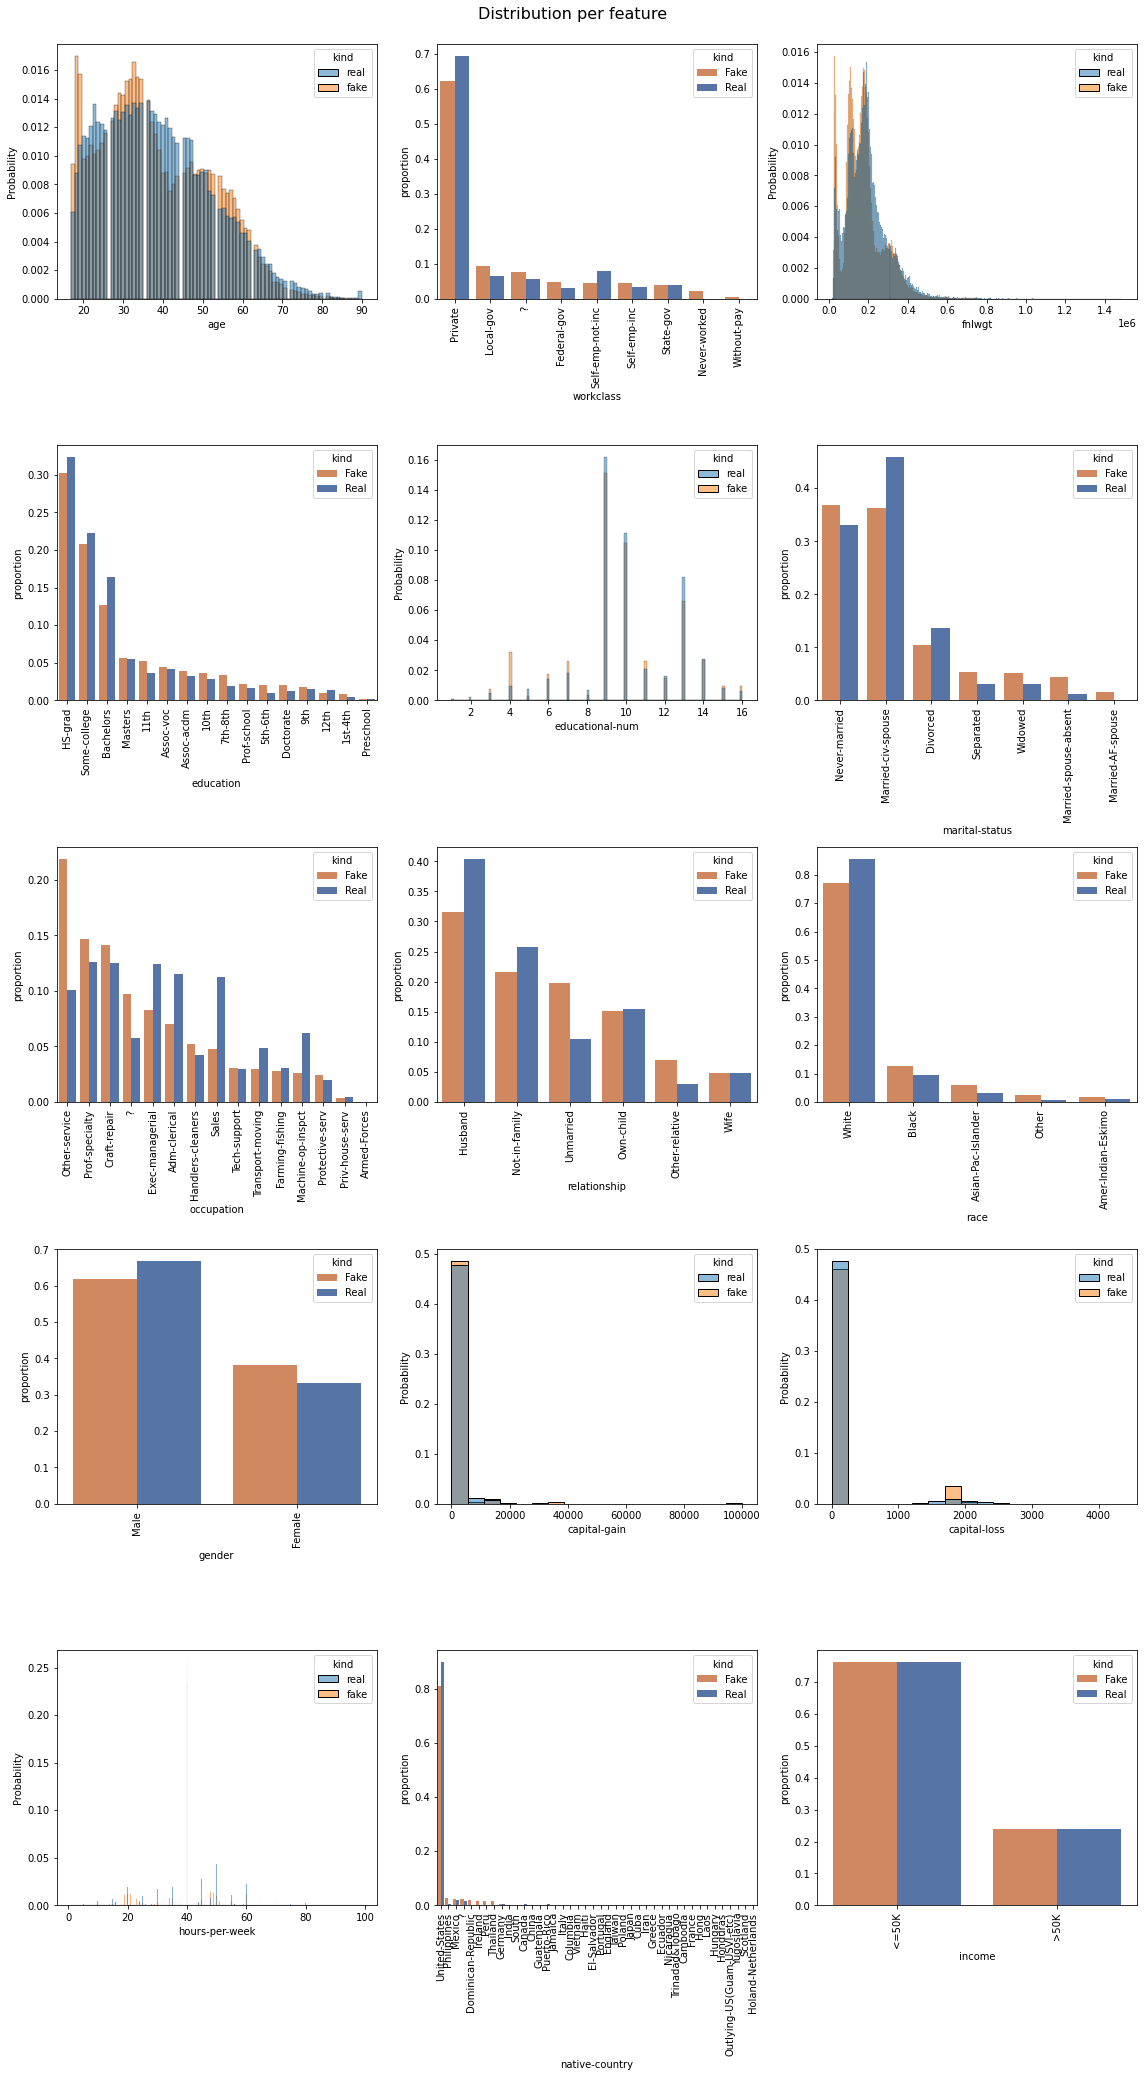

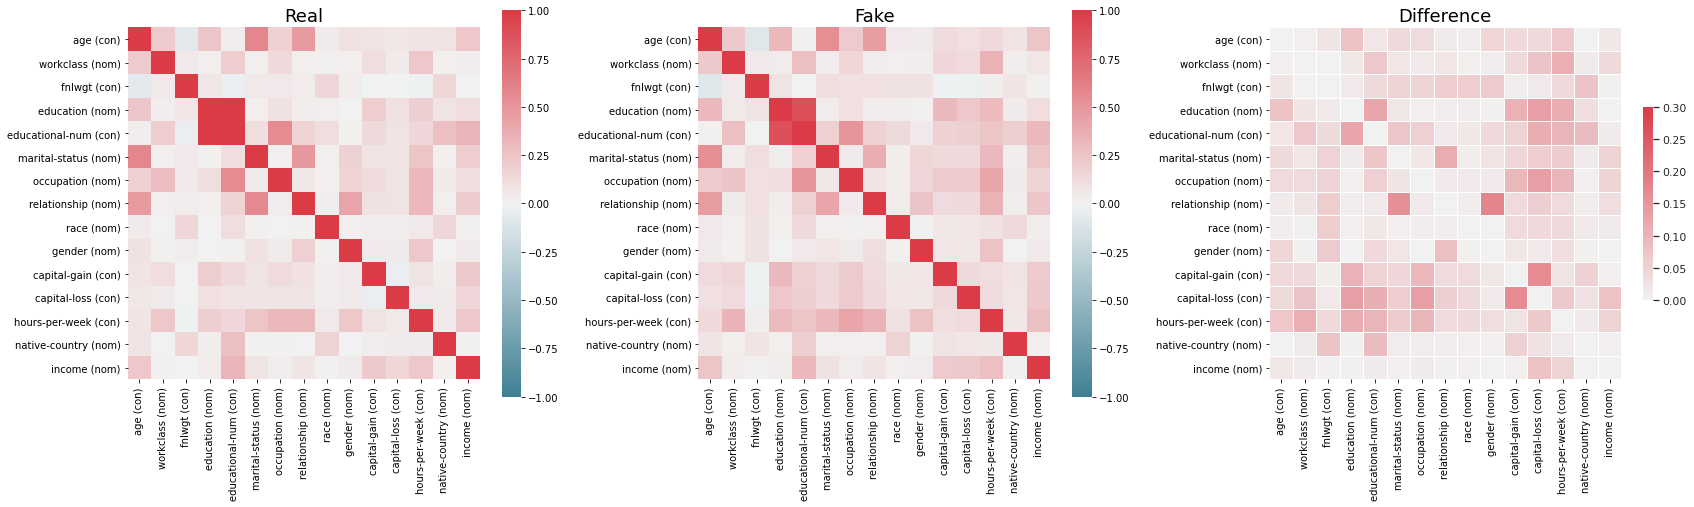

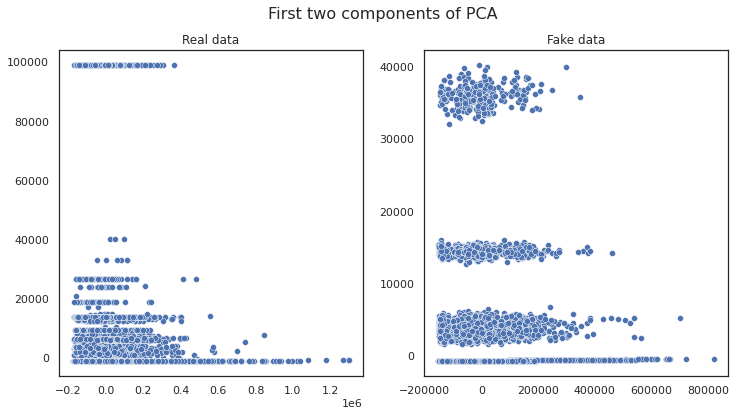

In [13]:
table_evaluator = TableEvaluator(real_data, synthetic_data)
table_evaluator.visual_evaluation()

**Build LGBM on original data as baseline and test on synthetic data**

In [14]:
real_data.drop(['education'],axis=1,inplace=True)

le_real = preprocessing.LabelEncoder()
for i in ['workclass','marital-status','occupation','relationship','race','gender','native-country']:
    real_data[i] = le_real.fit_transform(real_data[i].astype(str))

real_data.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,7,4,7,3,2,1,0,0,40,39,<=50K
1,38,4,89814,9,2,5,0,4,1,0,0,50,39,<=50K
2,28,2,336951,12,2,11,0,4,1,0,0,40,39,>50K
3,44,4,160323,10,2,7,0,2,1,7688,0,40,39,>50K
4,18,0,103497,10,4,0,3,4,0,0,0,30,39,<=50K


In [15]:
scaler_real = StandardScaler()

X_real = scaler_real.fit_transform(real_data.drop('income', 1))
y_real = real_data['income'].values

X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.3, stratify = y_real, random_state=42)

              precision    recall  f1-score   support

       <=50K       0.95      0.83      0.88     11147
        >50K       0.61      0.86      0.71      3506

    accuracy                           0.83     14653
   macro avg       0.78      0.84      0.80     14653
weighted avg       0.87      0.83      0.84     14653



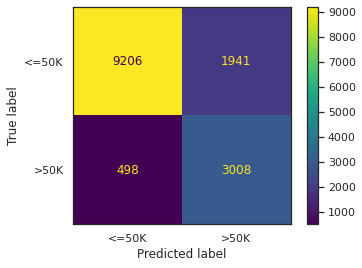

In [16]:
lgb_real = lgb.LGBMClassifier(class_weight='balanced')
lgb_real.fit(X_train, y_train)

y_pred = lgb_real.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_real, X_test, y_test)
plt.show()

Testing original LGBM model on synthetic data

In [17]:
synthetic_data.drop(['education'],axis=1,inplace=True)

le_synthetic = preprocessing.LabelEncoder()
for i in ['workclass','marital-status','occupation','relationship','race','gender','native-country']:
    synthetic_data[i] = le_synthetic.fit_transform(synthetic_data[i].astype(str))

synthetic_data.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,28,4,421412,9,3,14,4,4,1,0,0,40,39,<=50K
1,38,4,146148,13,2,4,0,4,1,0,0,40,39,<=50K
2,58,4,100955,3,3,8,2,4,1,0,0,21,26,<=50K
3,36,4,100018,14,4,10,1,1,1,0,0,40,30,<=50K
4,31,4,169094,13,3,4,1,1,1,0,1793,40,21,<=50K


In [18]:
y_synthetic = synthetic_data['income']
X_synthetic_scaled = pd.DataFrame(scaler_real.transform(synthetic_data.drop('income', axis=1)))
X_synthetic_scaled.columns = synthetic_data.drop('income', axis=1).columns
X_synthetic_scaled.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,-0.776316,0.088484,2.194521,-0.419335,0.252871,1.754488,1.595817,0.392384,0.70422,-0.144804,-0.217127,-0.034087,0.289462
1,-0.046942,0.088484,-0.412073,1.136512,-0.410397,-0.609318,-0.900852,0.392384,0.70422,-0.144804,-0.217127,-0.034087,0.289462
2,1.411808,0.088484,-0.840025,-2.753106,0.252871,0.336204,0.347482,0.392384,0.70422,-0.144804,-0.217127,-1.567419,-1.382507
3,-0.192816,0.088484,-0.848898,1.525474,0.916138,0.808965,-0.276685,-3.153810,0.70422,-0.144804,-0.217127,-0.034087,-0.868055
4,-0.557504,0.088484,-0.194788,1.136512,0.252871,-0.609318,-0.276685,-3.153810,0.70422,-0.144804,4.232000,-0.034087,-2.025572


              precision    recall  f1-score   support

       <=50K       0.91      0.88      0.89     37155
        >50K       0.64      0.71      0.68     11687

    accuracy                           0.84     48842
   macro avg       0.78      0.79      0.78     48842
weighted avg       0.84      0.84      0.84     48842



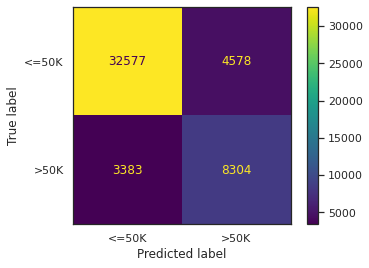

In [19]:
y_pred_synthetic = lgb_real.predict(X_synthetic_scaled)

# evaluation
print(classification_report(y_synthetic, y_pred_synthetic))
plot_confusion_matrix(lgb_real, X_synthetic_scaled, y_synthetic)
plt.show()

**Build LGBM on synthetic data and test on original data**

In [20]:
real_data = pd.read_csv('adult.csv')
synthetic_data = pd.concat([synthetic_data_0,synthetic_data_1])

In [21]:
synthetic_data.drop(['education'], axis=1, inplace=True)

le_synthetic = preprocessing.LabelEncoder()
for i in ['workclass','marital-status','occupation','relationship','race','gender','native-country']:
    synthetic_data[i] = le_synthetic.fit_transform(synthetic_data[i].astype(str))

synthetic_data.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,28,4,421412,9,3,14,4,4,1,0,0,40,39,<=50K
1,38,4,146148,13,2,4,0,4,1,0,0,40,39,<=50K
2,58,4,100955,3,3,8,2,4,1,0,0,21,26,<=50K
3,36,4,100018,14,4,10,1,1,1,0,0,40,30,<=50K
4,31,4,169094,13,3,4,1,1,1,0,1793,40,21,<=50K


In [22]:
scaler_synthetic = StandardScaler()

X_synthetic = scaler_synthetic.fit_transform(synthetic_data.drop('income', 1))
y_synthetic = synthetic_data['income'].values

X_train, X_test, y_train, y_test = train_test_split(X_synthetic, y_synthetic, test_size=0.3, stratify = y_synthetic, random_state=42)

              precision    recall  f1-score   support

       <=50K       0.94      0.82      0.87     11147
        >50K       0.59      0.83      0.69      3506

    accuracy                           0.82     14653
   macro avg       0.76      0.82      0.78     14653
weighted avg       0.86      0.82      0.83     14653



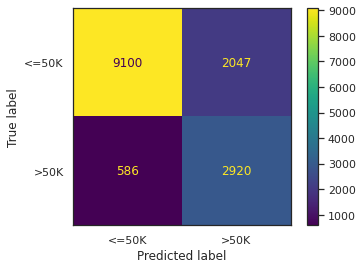

In [23]:
lgb_synthetic = lgb.LGBMClassifier(class_weight='balanced')
lgb_synthetic.fit(X_train, y_train)

y_pred = lgb_synthetic.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_synthetic, X_test, y_test)
plt.show()

Testing synthetic LGBM model on real data

In [24]:
real_data.drop(['education'], axis=1, inplace=True)

le_real = preprocessing.LabelEncoder()
for i in ['workclass','marital-status','occupation','relationship','race','gender','native-country']:
    real_data[i] = le_real.fit_transform(real_data[i].astype(str))

real_data.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,7,4,7,3,2,1,0,0,40,39,<=50K
1,38,4,89814,9,2,5,0,4,1,0,0,50,39,<=50K
2,28,2,336951,12,2,11,0,4,1,0,0,40,39,>50K
3,44,4,160323,10,2,7,0,2,1,7688,0,40,39,>50K
4,18,0,103497,10,4,0,3,4,0,0,0,30,39,<=50K


In [25]:
y_real = real_data['income']
X_real_scaled = pd.DataFrame(scaler_synthetic.transform(real_data.drop('income', axis=1)))
X_real_scaled.columns = real_data.drop('income', axis=1).columns
X_real_scaled.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,-0.948239,0.239357,0.574755,-0.985234,0.691775,0.158450,0.687735,-1.419579,0.785368,-0.192469,-0.289535,0.185577,0.390346
1,0.003435,0.239357,-0.805522,-0.278022,-0.595375,-0.345162,-1.095192,0.509074,0.785368,-0.192469,-0.289535,1.080405,0.390346
2,-0.728622,-0.998208,1.684604,0.782795,-0.595375,1.165672,-1.095192,0.509074,0.785368,-0.192469,-0.289535,0.185577,0.390346
3,0.442669,0.239357,-0.095081,0.075583,-0.595375,0.158450,-1.095192,-1.419579,0.785368,2.007151,-0.289535,0.185577,0.390346
4,-1.460678,-2.235773,-0.667653,0.075583,0.691775,-1.604190,0.687735,0.509074,-1.273288,-0.192469,-0.289535,-0.709250,0.390346


              precision    recall  f1-score   support

       <=50K       0.96      0.71      0.82     37155
        >50K       0.50      0.90      0.64     11687

    accuracy                           0.76     48842
   macro avg       0.73      0.80      0.73     48842
weighted avg       0.85      0.76      0.77     48842



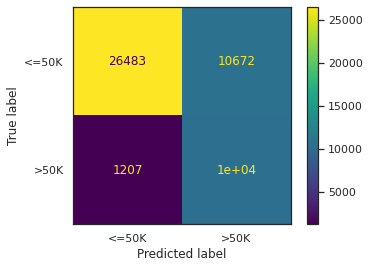

In [26]:
y_pred_real = lgb_synthetic.predict(X_real_scaled)

# evaluation
print(classification_report(y_real, y_pred_real))
plot_confusion_matrix(lgb_synthetic, X_real_scaled, y_real)
plt.show()